In [1]:
import numpy as np
import numpy
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from time import time
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2


In [2]:
import tensorflow as tf
# tf.enable_eager_execution()

In [3]:
sys.path.append('../code/utils/')
sys.path.append('../code/flowpm/')
import tools
from background import *
import tfpm 
import tfpmfuncs as tfpf
from tfpmconfig import Config


# PM

In [4]:
def pm(config, verbose=False):
    g = tf.Graph()
    with g.as_default():
        linear = tfpm.linfield(config, name='linear')
        icstate = tfpm.lptinit(linear, config, name='icstate')
        fnstate = tfpm.nbody(icstate, config, verbose=verbose, name='fnstate')
        final = tf.zeros_like(linear)
        final = tfpf.cic_paint(final, fnstate[0], boxsize=bs, name='final')
        tf.add_to_collection('pm', [linear, icstate, fnstate, final])
    return g


In [5]:
pkfile = '../code/flowpm/Planck15_a1p00.txt'
config = Config(bs=100, nc=32, seed=100, pkfile=pkfile)
bs, nc = config['boxsize'], config['nc']

g = pm(config, verbose=True)

with tf.Session(graph=g) as sess:
    sess.run(tf.global_variables_initializer())
    linear = g.get_tensor_by_name('linear:0')
    final = g.get_tensor_by_name('final:0')
    fnstate = g.get_tensor_by_name('fnstate:0')
    icstate = g.get_tensor_by_name('icstate:0')
    linmesh, finmesh, fstate,istate = sess.run([linear, final, fnstate, icstate])
#     linmesh, finmesh, fstate,istate = sess.run([linear, final, fnstate, icstate])


F 0.1 0.1 0.1
K 0.1 0.1 0.18027756377319948
D 0.1 0.18027756377319948 0.325
F 0.1 0.325 0.325
K 0.18027756377319948 0.325 0.325
K 0.325 0.325 0.4227883631321941
D 0.325 0.4227883631321941 0.55
F 0.325 0.55 0.55
K 0.4227883631321941 0.55 0.55
K 0.55 0.55 0.6528782428600298
D 0.55 0.6528782428600298 0.775
F 0.55 0.775 0.775
K 0.6528782428600298 0.775 0.775
K 0.775 0.775 0.8803408430829505
D 0.775 0.8803408430829505 1.0
F 0.775 1.0 1.0
K 0.8803408430829505 1.0 1.0


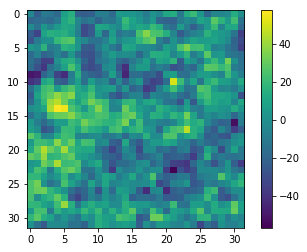

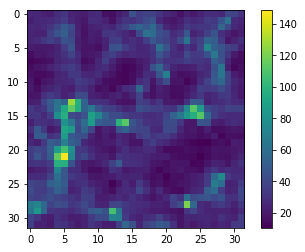

In [6]:
im = plt.imshow(linmesh.sum(axis=0))
plt.colorbar(im)
plt.show()
im = plt.imshow(finmesh.sum(axis=0))
plt.colorbar(im)
plt.show()


# Reconstruction

## Generate Data

In [7]:
#Generate DATA

pkfile = '../code/flowpm/Planck15_a1p00.txt'
config = Config(bs=100, nc=32, seed=100, pkfile=pkfile)
bs, nc = config['boxsize'], config['nc']


tf.reset_default_graph()

g = pm(config)


with tf.Session(graph = g) as sess:
    sess.run(tf.global_variables_initializer())
    linear = g.get_tensor_by_name('linear:0')
    final = g.get_tensor_by_name('final:0')
    truth, data = sess.run([linear, final])

    
sigma = 0.01**0.5
np.random.seed(100)
noise = np.random.normal(loc=0, scale=sigma, size=nc**3).reshape(nc, nc, nc).astype(config['dtype'])
datan = data + noise



Text(0.5, 1.0, 'DataN')

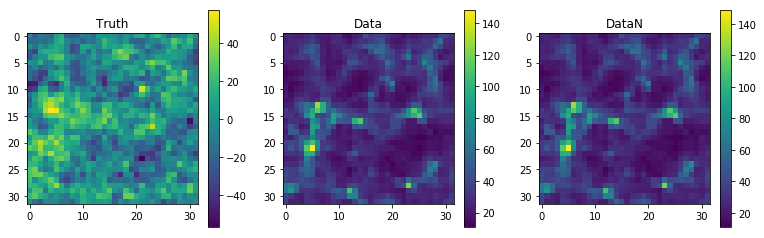

In [8]:
fig, ax = plt.subplots(1, 3, figsize = (13, 4))
im = ax[0].imshow(truth.sum(axis=0))
plt.colorbar(im, ax=ax[0])
ax[0].set_title('Truth')
im = ax[1].imshow(data.sum(axis=0))
plt.colorbar(im, ax=ax[1])
ax[1].set_title('Data')
im = ax[2].imshow(datan.sum(axis=0))
plt.colorbar(im, ax=ax[2])
ax[2].set_title('DataN')



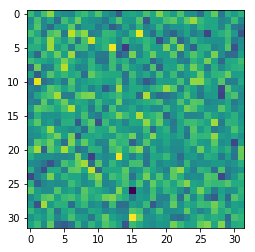

In [9]:
plt.imshow((data-datan).sum(axis=0))

## GD recon with Tflow

In [42]:
tf.reset_default_graph()

kmesh = sum(kk**2 for kk in config['kvec'])**0.5
priorwt = config['ipklin'](kmesh)
# priorwt

linear = tf.get_variable('linmesh', shape=(nc, nc, nc), 
                         initializer=tf.random_normal_initializer(), trainable=True)
icstate = tfpm.lptinit(linear, config)
fnstate = tfpm.nbody(icstate, config, verbose=False)
final = tf.zeros_like(linear)
final = tfpf.cic_paint(final, fnstate[0], boxsize=bs)
#

lineark = tfpf.r2c3d(linear, norm=nc**3)
priormesh = tf.square(tf.cast(tf.abs(lineark), tf.float32))
prior = tf.reduce_sum(tf.multiply(priormesh, priorwt))
prior = tf.multiply(prior, 1/nc**3)

sigma = 0.01**0.5

residual = tf.subtract(final, data)
residual = tf.multiply(residual, 1/sigma)

Rsm = tf.placeholder(tf.float32, name='smoothing')

# Rsm = tf.multiply(Rsm, bs/nc)
# Rsmsq = tf.multiply(Rsm, Rsm)
# smwts = tf.exp(tf.multiply(-kmesh**2, Rsmsq))
# residualk = tfpf.r2c3d(residual, norm=nc**3)
# residualk = tf.multiply(residualk, tf.cast(smwts, tf.complex64))
# residual = tfpf.c2r3d(residualk, norm=nc**3)

chisq = tf.multiply(residual, residual)
chisq = tf.reduce_sum(chisq)
chisq = tf.multiply(chisq, 1/nc**3)

loss = tf.add(chisq, prior)


lr = tf.placeholder(tf.float32, name='learningrate')
optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
opt_op = optimizer.minimize(loss, var_list=[linear])
# opt_op = optimizer.minimize(loss)

niter = 100
lr0 = 50
nlr, lrfac = 300, 2
nprint = 300
R0 = 0.

with tf.Session() as sess:
    losses = []
    sess.run(tf.global_variables_initializer())
    l, init = sess.run([loss, linear], {Rsm:0.})
    losses.append(l)
    #
    start, curr = time(), time()
    
    lp = l
    for it in range(niter+1):
#         print(it)
        _, l = sess.run([opt_op, loss], feed_dict={lr:lr0, Rsm:R0})

        if it % nlr == 0:
            lr0 /= lrfac
            print('reduce learning rate by factor of %0.2f. New learning rate = %0.2e'%(lrfac, lr0))

        #Anneal
        if (R0 > 0) and (abs(l-lp)/lp < 0.001):
            R0 /= 2
            print('reduced R0 to : %0.2f, at iteration = %d'%(R0, it))
        lp = l
        if R0 and R0 < 0.5: 
            R0 = 0
            print('R0 = 0')
        if it % nprint == 0:
            end = time()
            print('Iter %d of %d : Loss= %0.4f\nTime taken for last batch = %0.3f, \
            \nTotal time elapsed = %0.3f'%(it, niter, l, end-curr, end - start))
            curr = end
            recon = sess.run(linear)

        losses.append(l)
    recon = sess.run(linear)


reduce learning rate by factor of 2.00. New learning rate = 2.50e+01
Iter 0 of 100 : Loss= 314.5593
Time taken for last batch = 2.216,             
Total time elapsed = 2.216


Text(0.5, 1.0, 'Recon')

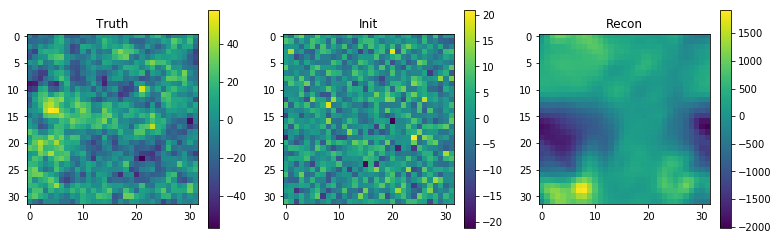

In [43]:
fig, ax = plt.subplots(1, 3, figsize = (13, 4))
im = ax[0].imshow(truth.sum(axis=0))
plt.colorbar(im, ax=ax[0])
ax[0].set_title('Truth')
im = ax[1].imshow(init.sum(axis=0))
plt.colorbar(im, ax=ax[1])
ax[1].set_title('Init')
im = ax[2].imshow(recon.sum(axis=0))
plt.colorbar(im, ax=ax[2])
ax[2].set_title('Recon')



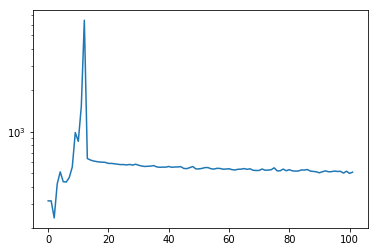

In [44]:
plt.plot(losses)
plt.yscale('log')

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


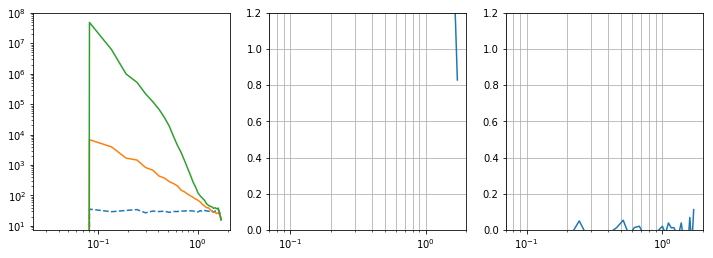

In [45]:
k, pt = tools.power(1+truth, boxsize=bs)
k, pi = tools.power(1+init, boxsize=bs)
k, pr = tools.power(1+recon, boxsize=bs)
k, px = tools.power(1+truth, 1+recon, boxsize=bs)

fig, ax = plt.subplots(1, 3, figsize = (12, 4))
ax[0].plot(k, pi, '--')
ax[0].plot(k, pt)
ax[0].plot(k, pr)
ax[0].loglog()

ax[1].plot(k, pr/pt)
ax[2].plot(k, px/(pr*pt)**.5)
for axis in ax[1:]: 
    axis.set_xscale('log')
    axis.set_ylim(0.0, 1.2)
    axis.grid(which='both')



### BFGS

In [9]:
# tf.reset_default_graph()

# kmesh = sum(kk**2 for kk in config['kvec'])**0.5
# priorwt = config['ipklin'](kmesh)

# # The objective function and the gradient.
# def lossfunc(linear):
#     icstate = tfpm.lptinit(linear, grid, config)
#     fnstate = tfpm.nbody(icstate, config, verbose=False)
#     final = tf.zeros_like(linear)
#     final = tfpf.cic_paint(final, fnstate[0], boxsize=bs)
#     #

#     lineark = tfpf.r2c3d(linear, norm=nc**3)
#     priormesh = tf.square(tf.cast(tf.abs(lineark), tf.float32))
#     prior = tf.reduce_sum(tf.multiply(priormesh, priorwt))
#     prior = tf.multiply(prior, 1/nc**3)

#     sigma = 0.01**0.5
#     residual = tf.subtract(final, data)
#     residual = tf.multiply(residual, 1/sigma)

#     chisq = tf.multiply(residual, residual)
#     chisq = tf.reduce_sum(chisq)
#     chisq = tf.multiply(chisq, 1/nc**3)

#     loss = tf.add(chisq, prior)
#     return loss, tf.gradients(loss, linear)[0]

    
    
# start = tf.get_variable('linmesh', shape=(nc, nc, nc), 
#                              initializer=tf.random_normal_initializer(), trainable=True)
# #start = tf.constant([0.6, 0.8])  # Starting point for the search.
# optim_results = tfp.optimizer.bfgs_minimize(lossfunc, initial_position=start, tolerance=1e-1, )

# with tf.Session() as session:
#     session.run(tf.global_variables_initializer())
#     results = session.run(optim_results)
#     # Check that the search converged
#     assert(results.converged)
#     # Check that the argmin is close to the actual value.
#     np.testing.assert_allclose(results.position, minimum)
#     # Print out the total number of function evaluations it took. Should be 6.
#     print ("Function evaluations: %d" % results.num_objective_evaluations)



## Scipy LBFGS recon

In [10]:
from tensorflow.contrib.opt import ScipyOptimizerInterface 

In [67]:
tf.reset_default_graph()


def reconmodel(config, data, sigma=0.01**0.5, maxiter=100):

    bs, nc = config['boxsize'], config['nc']
    kmesh = sum(kk**2 for kk in config['kvec'])**0.5
    priorwt = config['ipklin'](kmesh) * bs ** -3 
    
    g = tf.Graph()

    with g.as_default():
        
        initlin = tf.placeholder(tf.float32, data.shape, name='initlin')
        linear = tf.get_variable('linmesh', shape=(nc, nc, nc), 
                             initializer=tf.random_normal_initializer(), trainable=True)
        initlin_op = linear.assign(initlin, name='initlin_op')
        #PM
        icstate = tfpm.lptinit(linear, config, name='icstate')
        fnstate = tfpm.nbody(icstate, config, verbose=False, name='fnstate')
        final = tf.zeros_like(linear)
        final = tfpf.cic_paint(final, fnstate[0], boxsize=bs, name='final')
        #
        #Prior
        lineark = tfpf.r2c3d(linear, norm=nc**3)
        priormesh = tf.square(tf.cast(tf.abs(lineark), tf.float32))
        prior = tf.reduce_sum(tf.multiply(priormesh, 1/priorwt))
        prior = tf.multiply(prior, 1/nc**3, name='prior')

        residual = tf.subtract(final, data)
        residual = tf.multiply(residual, 1/sigma)

        chisq = tf.multiply(residual, residual)
        chisq = tf.reduce_sum(chisq)
        chisq = tf.multiply(chisq, 1/nc**3, name='chisq')

        loss = tf.add(chisq, prior, name='loss')
        
        optimizer = ScipyOptimizerInterface(loss, var_list=[linear], method='L-BFGS-B', 
                                            options={'maxiter': maxiter})
        
        tf.add_to_collection('inits', [initlin_op, initlin])
        tf.add_to_collection('opt', optimizer)
        tf.add_to_collection('diagnostics', [prior, chisq, loss])
        tf.add_to_collection('reconpm', [linear, final, fnstate])
        tf.add_to_collection('data', data)
    return g
    

recong = reconmodel(config, datan, sigma=sigma, maxiter=10)



In [68]:
losses = []
def call_loss(l):
    if len(losses) % 100 == 0: print(l)
    losses.append(l)
    
    
###Initialize
# initval = np.ones_like(datan, dtype=config['dtype'])
# initval = reconscp.copy()

initval = None
with tf.Session(graph=recong) as session:
    g = session.graph
    session.run(tf.global_variables_initializer())
    linmesh = g.get_tensor_by_name("linmesh:0")
    optimizer = g.get_collection_ref('opt')[0]
    loss = g.get_tensor_by_name('loss:0')
    chisq = g.get_tensor_by_name('chisq:0')
    prior = g.get_tensor_by_name('prior:0')

    if initval is not None:
        print('Do init')
        initlinop = g.get_operation_by_name('initlin_op')
        initlin = g.get_tensor_by_name('initlin:0')
        session.run(initlinop, {initlin:initval})
        
    initscp = session.run(linmesh)
    optimizer.minimize(session, loss_callback=call_loss, fetches=[[loss, chisq, prior]])
    reconscp = session.run(linmesh)
    



[317.63205, 317.14874, 0.483321]
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 97.917397
  Number of iterations: 10
  Number of functions evaluations: 15


Text(0.5, 1.0, 'Recon')

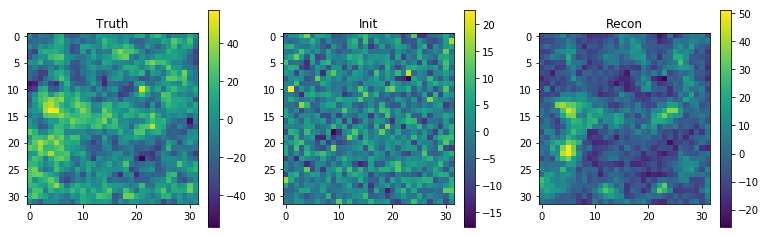

In [69]:
fig, ax = plt.subplots(1, 3, figsize = (13, 4))
im = ax[0].imshow(truth.sum(axis=0))
plt.colorbar(im, ax=ax[0])
ax[0].set_title('Truth')
im = ax[1].imshow(initscp.sum(axis=0))
plt.colorbar(im, ax=ax[1])
ax[1].set_title('Init')
im = ax[2].imshow(reconscp.sum(axis=0))
plt.colorbar(im, ax=ax[2])
ax[2].set_title('Recon')



In [39]:
# tf.reset_default_graph()

# kmesh = sum(kk**2 for kk in config['kvec'])**0.5
# priorwt = config['ipklin'](kmesh) * bs ** -3 #/ nc **-3

# # The objective function and the gradient.
# initlin = tf.placeholder(tf.float32, data.shape)
# # linear = tf.Variable(initlin, trainable=True)
# linear = tf.get_variable('linmesh', shape=(nc, nc, nc), 
#                              initializer=tf.random_normal_initializer(), trainable=True)
# initlinop = linear.assign(initlin)
# icstate = tfpm.lptinit(linear, config)
# fnstate = tfpm.nbody(icstate, config, verbose=False)
# final = tf.zeros_like(linear)
# final = tfpf.cic_paint(final, fnstate[0], boxsize=bs)
# #

# lineark = tfpf.r2c3d(linear, norm=nc**3)
# priormesh = tf.square(tf.cast(tf.abs(lineark), tf.float32))
# prior = tf.reduce_sum(tf.multiply(priormesh, 1/priorwt))
# prior = tf.multiply(prior, 1/nc**3)

# residual = tf.subtract(final, datan)
# residual = tf.multiply(residual, 1/sigma)

# chisq = tf.multiply(residual, residual)
# chisq = tf.reduce_sum(chisq)
# chisq = tf.multiply(chisq, 1/nc**3)

# loss = tf.add(chisq, prior)
    
    
# # optimizer = ScipyOptimizerInterface(loss, var_list=[linear],  
# #                                     x0=np.ones_like(data), method='L-BFGS-B', options={'maxiter': 1000})
# optimizer = ScipyOptimizerInterface(loss, var_list=[linear],method='L-BFGS-B', options={'maxiter': 100})

# with tf.Session() as session:
#     session.run(tf.global_variables_initializer())
# #     session.run(initlinop, {initlin:np.zeros((nc, nc, nc), dtype=np.float32)})
# #     session.run(initlinop, {initlin:truth})
#     session.run(initlinop, {initlin:np.random.normal(size=nc**3).reshape(nc, nc, nc)})
#     initscp = session.run(linear)
#     optimizer.minimize(session)
#     reconscp = session.run(linear)
    

    

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 4.841894
  Number of iterations: 100
  Number of functions evaluations: 107


/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


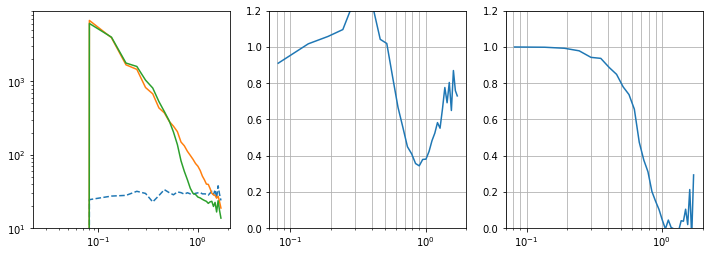

In [41]:
k, pt = tools.power(1+truth, boxsize=bs)
k, pi = tools.power(1+initscp, boxsize=bs)
k, pr = tools.power(1+reconscp, boxsize=bs)
k, px = tools.power(1+truth, 1+reconscp, boxsize=bs)

fig, ax = plt.subplots(1, 3, figsize = (12, 4))
ax[0].plot(k, pi, '--')
ax[0].plot(k, pt)
ax[0].plot(k, pr)
ax[0].loglog()

ax[1].plot(k, pr/pt)
ax[2].plot(k, px/(pr*pt)**.5)
for axis in ax[1:]: 
    axis.set_xscale('log')
    axis.set_ylim(0.0, 1.2)
    axis.grid(which='both')


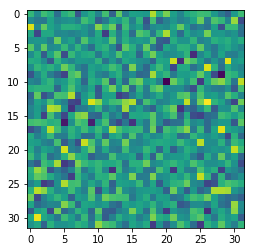

In [108]:
plt.imshow((truth - initscp2).sum(axis=0))

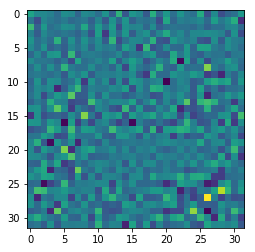

In [109]:
plt.imshow((truth - reconscp2).sum(axis=0))

# Check

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


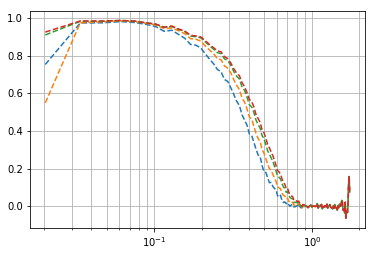

In [14]:
infolder = '../code/recon/L0400_N0128_S0100//'
bs, nc = 400, 128
truemesh = np.load(infolder + 'linear.f4.npy')
k, pt = tools.power(1+truemesh, boxsize=bs)
for j, it in enumerate([1000, 2000, 4000, 7000]):
    reconmesh = np.load(infolder + 'recon_%04d.f4.npy'%it)

    k, pr = tools.power(1+reconmesh, boxsize=bs)
    k, px = tools.power(1+truemesh, 1+reconmesh, boxsize=bs)
#     plt.plot(k, pr/pt, 'C%d'%j)
    plt.plot(k, px/(pr*pt)**.5, 'C%d--'%j)
plt.xscale('log')
# plt.ylim(0.5, 1.5)
plt.grid(which='both')

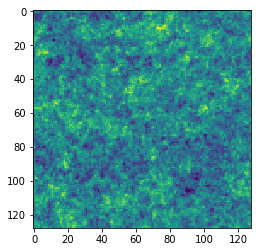

In [11]:
plt.imshow(truemesh.sum(axis=0))

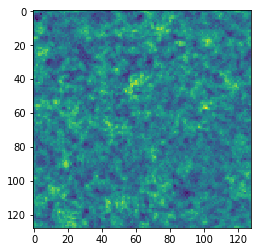

In [12]:
plt.imshow(reconmesh.sum(axis=0))

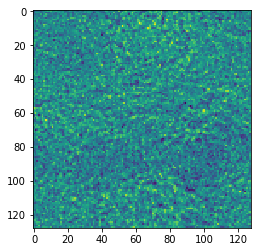

In [13]:
plt.imshow((truemesh-reconmesh).sum(axis=0))

# Profile

In [5]:
# # Create options to profile the time and memory information.
# builder = tf.profiler.ProfileOptionBuilder
# opts = builder(builder.time_and_memory()).order_by('micros').build()
# # Create a profiling context, set constructor argument `trace_steps`,
# # `dump_steps` to empty for explicit control.
# with tf.contrib.tfprof.ProfileContext('./tmp/train_dir',
#                                       trace_steps=[],
#                                       dump_steps=[]) as pctx:
#     with tf.Session(graph=g) as sess:
#         # Enable tracing for next session.run.
#         pctx.trace_next_step()
#         # Dump the profile to '/tmp/train_dir' after the step.
#         pctx.dump_next_step()
#         _ = sess.run(g.get_tensor_by_name('res:0'))
#         pctx.profiler.profile_operations(options=opts)

In [ ]:
# import tensorflow as tf
# from tensorflow.python.client import timeline

# def model():
#     g = tf.Graph()
#     with g.as_default():
#         a = tf.random_normal([20, 50])
#         b = tf.random_normal([50, 10])
#         res = tf.matmul(a, b, name='res')
#     return g

# g = model()

# tmp = tf.profiler.profile(g, cmd='op')
# # with tf.Session() as sess:
# #     # add additional options to trace the session execution
# #     options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
# #     run_metadata = tf.RunMetadata()
# #     sess.run(res, options=options, run_metadata=run_metadata)

# #     # Create the Timeline object, and write it to a json file
# #     fetched_timeline = timeline.Timeline(run_metadata.step_stats)
# #     chrome_trace = fetched_timeline.generate_chrome_trace_format()
# #     with open('timeline_01.json', 'w') as f:
# #         f.write(chrome_trace)

In [41]:
# pkfile = '../code/flowpm/Planck15_a1p00.txt'
# config = Config(bs=100, nc=32, seed=100, stages = np.linspace(0.01, 1, 3), pkfile=pkfile)
# bs, nc = config['boxsize'], config['nc']
# grid = bs/nc*np.indices((nc, nc, nc)).reshape(3, -1).T.astype(np.float32)

# tf.reset_default_graph()
# def flowpm(config):
#     g = tf.Graph()
#     with g.as_default():
#         linear = tfpm.linfield(config)
#         lineark = tfpf.r2c3d(linear, config)
#         icstate = tfpm.lptinit(lineark, grid, config)
#         fnstate = tfpm.nbody(icstate, config, verbose=False)
#         final = tf.zeros_like(linear)
#         final = tfpf.cic_paint(final, fnstate[0], boxsize=bs)
#     return g

# pmgraph = flowpm(config)

In [118]:
pkfile = '../code/flowpm/Planck15_a1p00.txt'
# config = Config(bs=100, nc=128, seed=100, stages = np.linspace(0.01, 1, 3), pkfile=pkfile)
config = Config(bs=100, nc=32, seed=100, pkfile=pkfile)
bs, nc = config['boxsize'], config['nc']
grid = bs/nc*np.indices((nc, nc, nc)).reshape(3, -1).T.astype(np.float32)

tf.reset_default_graph()
linear = tfpm.linfield(config)
lineark = tfpf.r2c3d(linear)
icstate = tfpm.lptinit(lineark, grid, config)
fnstate = tfpm.nbody(icstate, config, verbose=False)
final = tf.zeros_like(linear)
final = tfpf.cic_paint(final, fnstate[0], boxsize=bs)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    linmesh, fstate, mesh = sess.run([linear, fnstate, final])


In [6]:
from time import time

In [55]:
%timeit tfpf.laplace(config)
%timeit tfpf.laplace2(config)
%timeit tfpf.gradient(config, 1)

19.9 ms ± 3.27 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
18.4 ms ± 3.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
18 µs ± 1.14 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [7]:
ic[0]

array([[ 4.7943942e-02, -1.7028974e-03,  6.7412019e-02],
       [ 4.3343827e-02, -7.0656775e-03,  3.1618800e+00],
       [ 6.9417059e-02, -7.3283422e-03,  6.2857866e+00],
       ...,
       [ 9.6902298e+01,  9.6875732e+01,  9.0616890e+01],
       [ 9.6874756e+01,  9.6856544e+01,  9.3798386e+01],
       [ 9.6868729e+01,  9.6846260e+01,  9.6938789e+01]], dtype=float32)

In [80]:
tf.reset_default_graph()

niter = 20 

tmesh = tf.zeros_like(mesh)
tpart = tf.Variable(0.)
tpart = tf.assign(tpart, ic[0], validate_shape=False)
result = tfpf.cic_paint(tmesh, tpart,  boxsize=bs)

times = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    totstart = time()
    for _ in range(niter):
        start = time()
        sess.run(result)
        end = time()
        times.append(end - start)
    totend = time()
print('Time taken for CIC - ', end - start, (totend-totstart)/niter)
np.array(times).mean(), np.array(times[1:]).mean()

Time taken for CIC -  0.11084651947021484 0.09658712148666382


(0.09658359289169312, 0.0800266140385678)

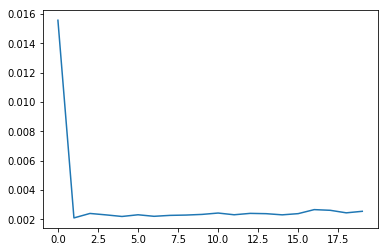

In [47]:
# plt.hist(times)
plt.plot(times)

In [48]:
tf.reset_default_graph()

tmesh = tf.zeros_like(mesh)
tpart = tf.Variable(0.)
tpart = tf.assign(tpart, ic[0], validate_shape=False)
result = tfpf.cic_readout(tmesh, tpart, boxsize=bs)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    start = time()
    for _ in range(niter):
        sess.run(result)
    end = time()
    print(end - start, (end-start)/niter)
print('Time taken for 100 readouts - ', end - start, (end-start)/niter)

0.06261467933654785 0.0031307339668273926
Time taken for 100 readouts -  0.06261467933654785 0.0031307339668273926


In [23]:
tf.reset_default_graph()

tmesh = tf.zeros_like(mesh)
tpart = tf.Variable(0.)
tpart = tf.assign(tpart, ic[0], validate_shape=False)
result = tfpf.cic_readout(tmesh, tpart, boxsize=bs)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    start = time()
    for _ in range(niter):
        sess.run(result)
    end = time()
    print(end - start, (end-start)/niter)
print('Time taken for 100 readouts - ', end - start, (end-start)/niter)

6.238195419311523 0.31190977096557615
Time taken for 100 readouts -  6.238195419311523 0.31190977096557615


In [88]:
tf.reset_default_graph()

tmesh = tf.zeros_like(mesh)
# tmesh = tf.cast(tmesh, tf.complex64)
result = tfpf.r2c3d(tmesh, config)

times = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    totstart = time()
    for _ in range(niter):
        start = time()
        sess.run(result)
        end = time()
        times.append(end - start)
    totend = time()
print('Time taken for r2c - ', end - start, (totend-totstart)/niter)

Time taken for r2c -  0.002713918685913086 0.03318428993225098


In [89]:
tf.reset_default_graph()

tmesh = tf.zeros_like(mesh)
# tmesh = tf.cast(tmesh, tf.complex64)
result = tfpf.r2c3d2(tmesh)

times = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    totstart = time()
    for _ in range(niter):
        start = time()
        sess.run(result)
        end = time()
        times.append(end - start)
    totend = time()
print('Time taken for r2c - ', end - start, (totend-totstart)/niter)

Time taken for r2c -  0.0028395652770996094 0.033509790897369385


In [90]:
tf.reset_default_graph()

tmesh = tf.zeros_like(mesh)
# tmesh = tf.cast(tmesh, tf.complex64)
result = tfpf.r2c3d2(tmesh, nc**3)

times = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    totstart = time()
    for _ in range(niter):
        start = time()
        sess.run(result)
        end = time()
        times.append(end - start)
    totend = time()
print('Time taken for r2c - ', end - start, (totend-totstart)/niter)

Time taken for r2c -  0.0026197433471679688 0.03126882314682007


In [25]:
tf.reset_default_graph()

tmesh = tf.zeros_like(mesh, dtype=tf.complex64)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    start = time()
    for _ in range(niter):
        sess.run(tfpf.c2r3d(tmesh, config))
    end = time()
    print(end - start, (end-start)/niter)
print('Time taken for 100 c2r - ', end - start, (end-start)/niter)

12.759227991104126 0.6379613995552063
Time taken for 100 c2r -  12.759227991104126 0.6379613995552063


N = 32, CIC = 0.166, r2c = 0.018

N = 64, CIC = 0.8, r2c = 0.07

# BFGS

In [19]:
import tensorflow_probability as tfp

In [20]:
minimum = np.array([1.0, 1.0])  # The center of the quadratic bowl.
scales = np.array([2.0, 3.0])  # The scales along the two axes.

# The objective function and the gradient.
def quadratic(x):
    value = tf.reduce_sum(scales * (x - minimum) ** 2)
    return value, tf.gradients(value, x)[0]

start = tf.constant([0.6, 0.8])  # Starting point for the search.
optim_results = tfp.optimizer.bfgs_minimize(quadratic, initial_position=start, tolerance=1e-8)

with tf.Session() as session:
    results = session.run(optim_results)
    # Check that the search converged
    assert(results.converged)
    # Check that the argmin is close to the actual value.
    np.testing.assert_allclose(results.position, minimum)
    # Print out the total number of function evaluations it took. Should be 6.
    print ("Function evaluations: %d" % results.num_objective_evaluations)


Function evaluations: 6


In [23]:
results.position


array([1., 1.], dtype=float32)

# Scipy

In [40]:
from tensorflow.contrib.opt import ScipyOptimizerInterface 

In [69]:
tf.reset_default_graph()

vector = tf.get_variable('vector', 2, initializer=tf.random_normal_initializer())
toadd = tf.Variable([1., 5])
# Make vector norm as small as possible.
loss = tf.reduce_sum(tf.square(tf.add(vector, toadd)))

optimizer = ScipyOptimizerInterface(loss, var_list=[vector],  method='L-BFGS-B', options={'maxiter': 5})

with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    optimizer.minimize(session)
    print(session.run([vector, toadd]))
# The value of vector should now be [0., 0.].


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.000000
  Number of iterations: 2
  Number of functions evaluations: 3
[array([-1.0000001, -5.       ], dtype=float32), array([1., 5.], dtype=float32)]


In [58]:
optimizer.optimizer_kwargs

{'method': 'L-BFGS-B', 'options': {'maxiter': 100}}